# SHAP Demo

Dataset: https://archive.ics.uci.edu/ml/datasets/Abalone

* Predicting the age of abalone from physical measurements.
* The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import shap

shap.initjs()

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Custom colors
positive_color = "#ca0020"
negative_color = "#92c5de"

# Default SHAP colors
default_pos_color = "#ff0051"
default_neg_color = "#008bfb"

# DPI
mpl.rcParams['figure.dpi'] = 110

## Dataset

In [4]:
abalone_df = pd.read_csv(
    "data/abalone.data",
    names=[
        "sex",
        "length",
        "diameter",
        "height",
        "whole weight",
        "shucked weight",
        "viscera weight",
        "shell weight",
        "rings",
    ],
)

print(len(abalone_df))
abalone_df.head()

4177


,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Comparing whole weight with the number of rings.

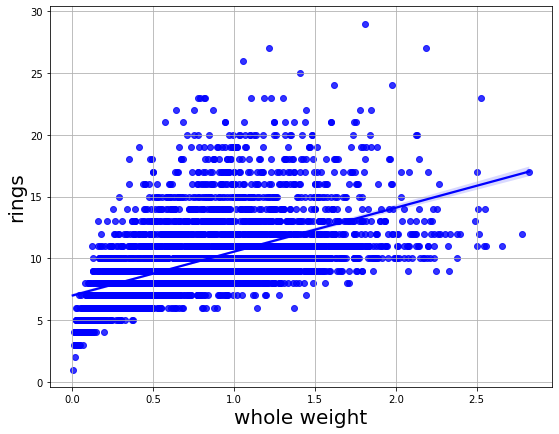

In [5]:
plt.figure(figsize=(9, 7))
sns.regplot(x=abalone_df["whole weight"], y=abalone_df["rings"], color='blue')
plt.ylabel("rings", size=20)
plt.xlabel("whole weight", size=20)
plt.grid()
plt.show()

Comparing how sex can be used to differentiate age (or number of rings) - Male (M), Female (F), and Infant (I).

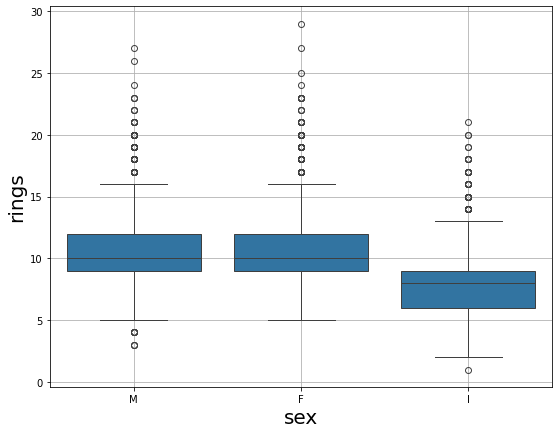

In [6]:
plt.figure(figsize=(9, 7))
sns.boxplot(x=abalone_df["sex"], y=abalone_df["rings"])
plt.ylabel("rings", size=20)
plt.xlabel("sex", size=20)
plt.grid()
plt.show()

Seeing the correlation among variables.

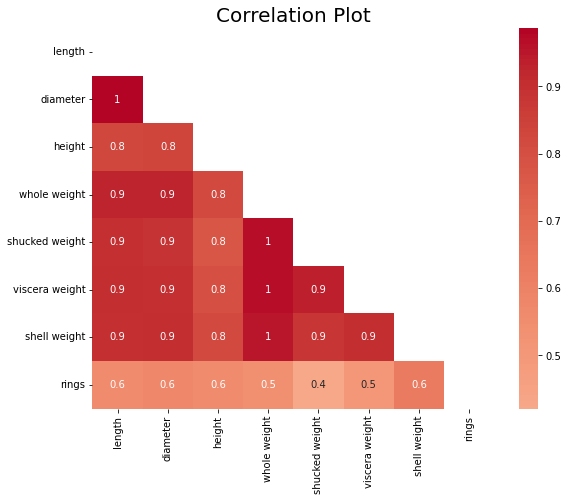

In [7]:
cont = [
    "length",
    "diameter",
    "height",
    "whole weight",
    "shucked weight",
    "viscera weight",
    "shell weight",
    "rings",
]
corr_matrix = pd.DataFrame(abalone_df[cont], columns=cont).corr()
plt.figure(figsize=(9, 7))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=True, fmt=".1g", mask=mask)
plt.title("Correlation Plot", size=20)
plt.show()

Weight, length and diameter seem to be highly correlated among each other.

## Feature Engineering

* Creating dataframe for predictions and features.
* One-Hot encoding categorical variables.

In [8]:
y = abalone_df["rings"]
X = abalone_df[
    ["sex", "length", "height", "shucked weight", "viscera weight", "shell weight"]
]

In [9]:
X["sex.M"] = [1 if s == "M" else 0 for s in X["sex"]]
X["sex.F"] = [1 if s == "F" else 0 for s in X["sex"]]
X["sex.I"] = [1 if s == "I" else 0 for s in X["sex"]]
X = X.drop("sex", axis=1)

X.head()

,length,height,shucked weight,viscera weight,shell weight,sex.M,sex.F,sex.I
0,0.455,0.095,0.2245,0.1010,0.150,1,0,0
1,0.350,0.090,0.0995,0.0485,0.070,1,0,0
2,0.530,0.135,0.2565,0.1415,0.210,0,1,0
3,0.440,0.125,0.2155,0.1140,0.155,1,0,0
4,0.330,0.080,0.0895,0.0395,0.055,0,0,1


Note that we're not scaling any variable.

## XGBoost Regressor

In [10]:
model = xgb.XGBRegressor(objective="reg:squarederror")
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

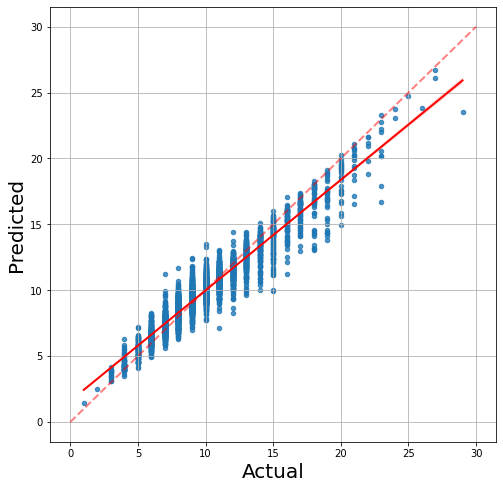

In [11]:
y_pred = model.predict(X)

plt.figure(figsize=(8, 8))
sns.regplot(
    x=y,
    y=y_pred,
    scatter_kws={"s": 20},
    line_kws={"color": "red", "linestyle": "-", "linewidth": 2},
)
plt.plot([0, 30], [0, 30], color="r", linestyle="--", linewidth=2, alpha=0.5)
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.grid()
plt.show()

In [12]:
# Calculate various evaluation metrics
mae = mean_absolute_error(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

# Print the metrics
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")


Mean Absolute Error (MAE): 0.7036
Mean Squared Error (MSE): 0.9751
Root Mean Squared Error (RMSE): 0.9875
R-squared (R2): 0.9062


## Standard SHAP values

In [13]:
explainer = shap.Explainer(model, algorithm='auto')
shap_values = explainer(X)

* The algorithm parameter is set to 'auto', which means SHAP will automatically choose the most suitable algorithm based on the characteristics of the model and data.
* In `XGBRegressor`, this ideally should be TreeSHAP.

In [14]:
np.shape(shap_values.values)

(4177, 8)

* SHAP creates an array of values.
* The `.values` attribute of a SHAP values object typically holds the actual computed Shapley values. 
* These values represent the contribution of each feature to the model's prediction for a specific instance.
* The output is of the form `(n_samples, n_features)`, where `n_samples` is the number of instances for which Shapley values are calculated, and `n_features` is the number of features in the model.

### Waterfall plot

In [15]:
shap_values[0]

.values =
array([ 0.36806285,  1.0587054 ,  0.94834965, -0.05403227, -0.43605894,
        0.3316413 , -0.04919233,  0.3216473 ], dtype=float32)

.base_values =
9.93266

.data =
array([0.455 , 0.095 , 0.2245, 0.101 , 0.15  , 1.    , 0.    , 0.    ])

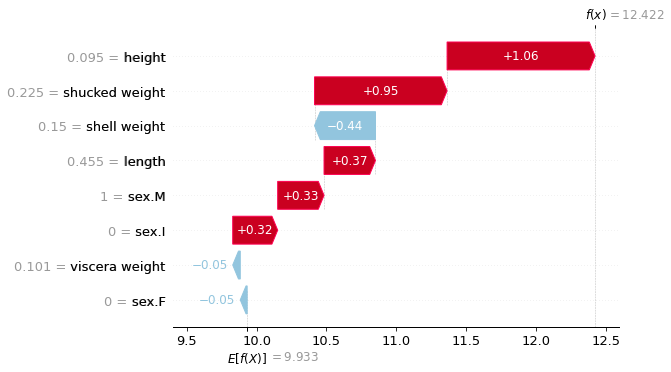

In [16]:
fig = plt.figure()
mpl.rcParams['figure.dpi'] = 110
shap.plots.waterfall(shap_values[0], show=False)

for fc in plt.gcf().get_children():
    for fcc in fc.get_children():
        if isinstance(fcc, mpl.patches.FancyArrow):
            if mpl.colors.to_hex(fcc.get_facecolor()) == default_pos_color:
                fcc.set_facecolor(positive_color)
            elif mpl.colors.to_hex(fcc.get_facecolor()) == default_neg_color:
                fcc.set_color(negative_color)
        elif isinstance(fcc, plt.Text):
            if mpl.colors.to_hex(fcc.get_color()) == default_pos_color:
                fcc.set_color(positive_color)
            elif mpl.colors.to_hex(fcc.get_color()) == default_neg_color:
                fcc.set_color(negative_color)
plt.show()

**Interpreting the Waterfall Plot:**

1. Base Value:
    - The plot typically starts with a bar representing the base value.
    - $E[f(X)] = 9.933$ or the average prediction from the model.
    - This is replicated accross all values.
    - This is the expected model output when no features are considered (the model's average prediction).
2. Contributions of Features:
    - Each subsequent bar represents the contribution of a specific feature to the deviation from the base value.
    - Bars to the right represent positive contributions, and bars to the left represent negative contributions.
    - The length of each bar represents the magnitude of the contribution.
3. Cumulative Impact: As you move from left to right, the plot accumulates the contributions, showing how each feature affects the
    final prediction.
4. Final Prediction: 
    - The final bar at the top represents the model's prediction for the specific instance.
    - $f(x) = 12.422$

### Absolute Mean SHAP

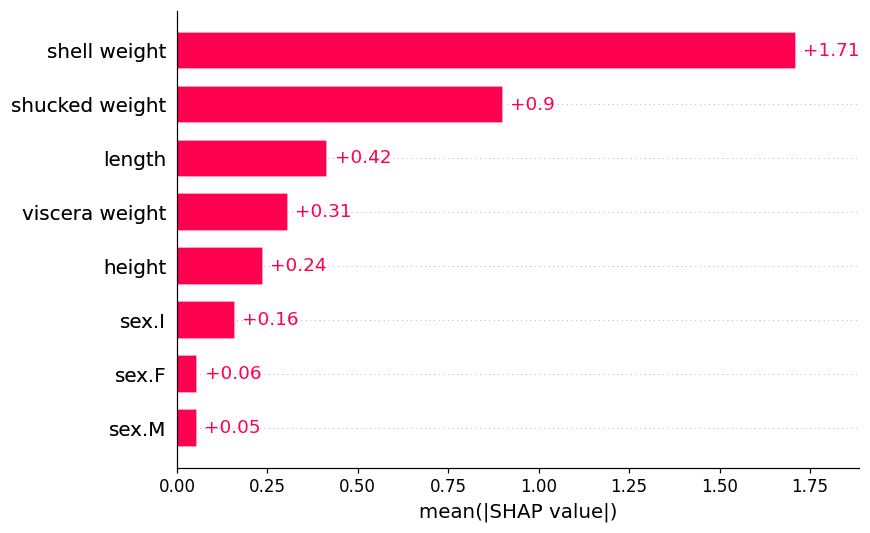

In [17]:
shap.plots.bar(shap_values)

* Each feature is represented by a vertical bar.
* The length of the bar indicates the average absolute Shapley value of that feature across all instances.
* Features with longer bars have a higher average impact on model predictions.

### Beeswarm plot

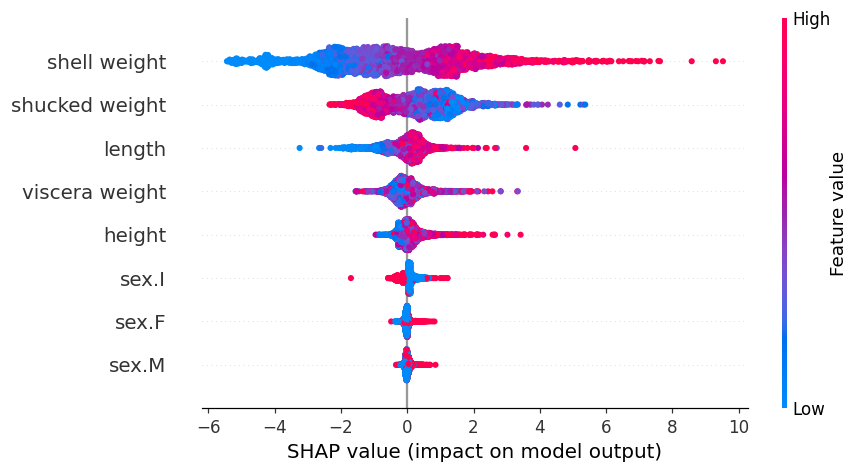

In [18]:
shap.plots.beeswarm(shap_values)

* Each point on the plot represents the Shapley value for a specific feature and instance.
* The x-axis represents the Shapley values, and the y-axis represents the features.

**Key observations from the beeswarm plot:**
1. Spread of Shapley Values: 
    - The spread of points for each feature indicates the variability of Shapley values across instances. 
    - Wider spreads suggest more variability.
    - `shell_weight` here has the highest spread.
2. Feature Importance: 
    - The distribution of points along the x-axis provides insights into the importance of each feature. 
    - Features with points more concentrated towards one end of the axis have a more consistent impact.
3. Direction of Impact:
    - The direction of the swarm (left or right on the x-axis) indicates whether the feature has a positive or negative impact on the model's predictions.

Interpreting some features:
* We can see that as the `shell weight` increases, the the impact it has on the model also increases.
* We can confirm this with the scatter plot in shapely.

### Dependence plots

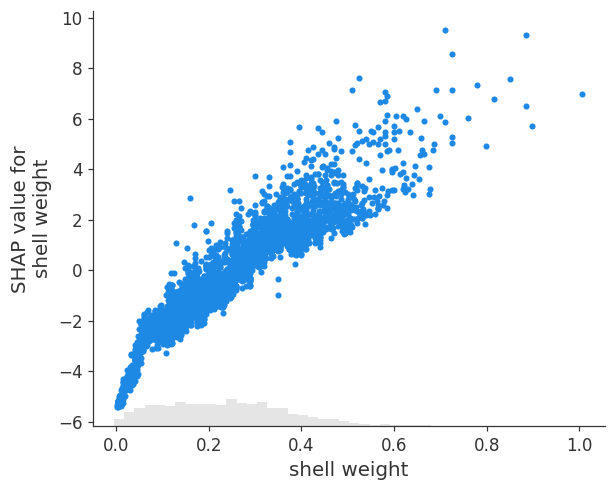

In [19]:
shap.plots.scatter(shap_values[:, "shell weight"])

* the above confirms that our model tends to predict higher or lower values based on the "shell weight" feature. 
* We can also see how `shucked weight` interacts with `shell weight` and changes as the SHAP value increases.

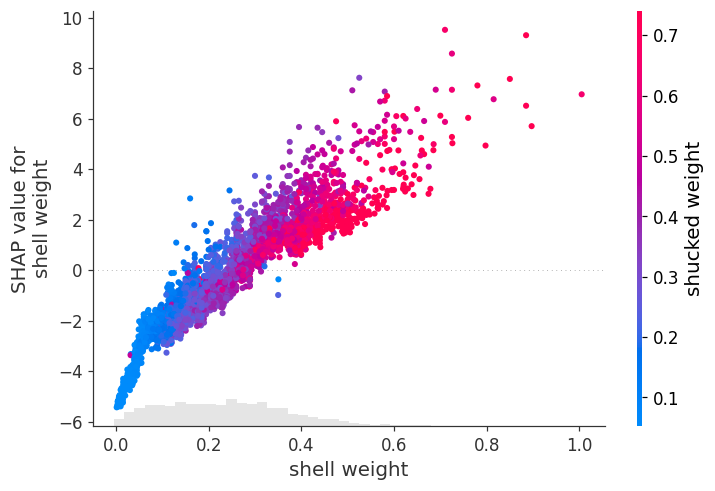

In [20]:
shap.plots.scatter(
    shap_values[:, "shell weight"], color=shap_values[:, "shucked weight"]
)

The opposite seems to occur with `shucked weight`.

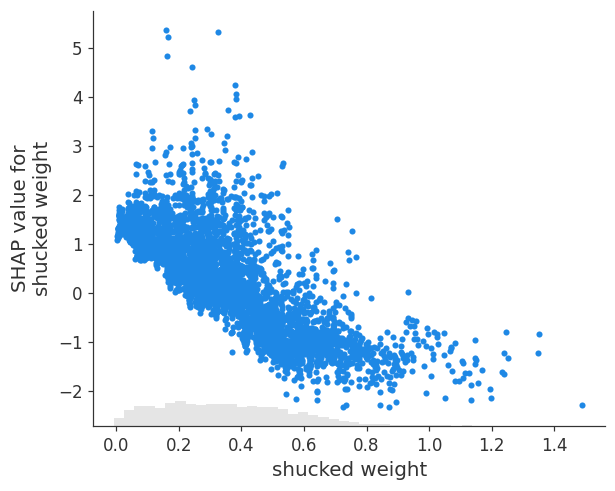

In [21]:
shap.plots.scatter(shap_values[:, "shucked weight"])

* As the weight increases, the lower the impact it has on the model's prediction.
* This might seem counter-intuitive at first, but this might be a result of the interaction between `shell weight` and `shuck weight`.
* This could suggest that `shell weight` might be enough to predict the final model's output.

### Calculating the prediction using SHAP values

In [22]:
shap_sum = shap_values.values.sum(axis=1) + explainer.expected_value
print(shap_sum.shape, y_pred.shape)

(4177,) (4177,)


In [23]:
df_check = pd.DataFrame({"SHAP sum": shap_sum, "Predicted probability": y_pred})
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
17,9.304787,9.304792
1131,8.194817,8.194820
299,8.796845,8.796850
1338,9.872873,9.872876
2383,13.105618,13.105622


In [24]:
np.allclose(df_check["SHAP sum"], df_check["Predicted probability"])

True

## Binary Target variables

In [25]:
# binary target variable
y_bin = [1 if y_ > 10 else 0 for y_ in y]

# train model
model_bin = xgb.XGBClassifier(objective="binary:logistic")
model_bin.fit(X, y_bin)

# get shap values
explainer = shap.Explainer(model_bin)
shap_values_bin = explainer(X)
print(shap_values_bin.shape)

(4177, 8)


In [26]:
shap_values_bin[0]

.values =
array([-3.7816179e-01, -7.5336806e-03,  9.1802502e-01, -1.8947421e-01,
       -1.1425363e+00,  4.0317979e-01,  9.1796322e-04,  5.1810247e-01],
      dtype=float32)

.base_values =
-0.7146312

.data =
array([0.455 , 0.095 , 0.2245, 0.101 , 0.15  , 1.    , 0.    , 0.    ])

* The Shapley values obtained using SHAP's Explainer will represent log-odds probabilities. 
* Specifically, the Shapley values indicate how the features contribute to the log-odds of the positive class.

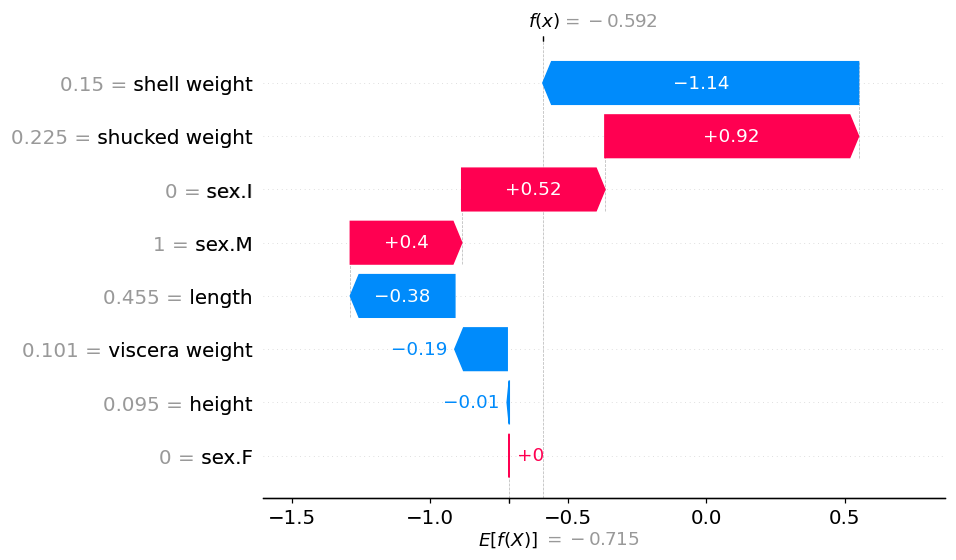

In [27]:
shap.plots.waterfall(shap_values_bin[0])

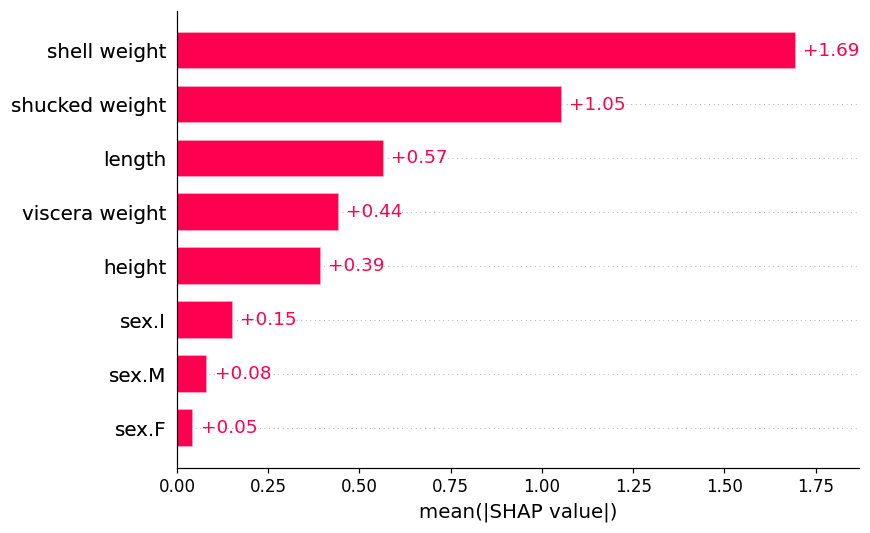

In [28]:
shap.plots.bar(shap_values_bin)

In [29]:
shap_sum_bin = shap_values_bin.values.sum(axis=1) + explainer.expected_value
print(shap_sum_bin.shape)

(4177,)


In [30]:
shap_sum_bin[0]

-0.59211195

* The sigmoid function transforms the log-odds into a probability between 0 and 1.
* The predicted probability is the likelihood of the positive class.

In [31]:
shap_sum_prob = 1 / (1 + np.exp(-1 * shap_sum_bin))

In [32]:
y_bin_preda = model_bin.predict_proba(X)[:,1]
print(y_bin_preda.shape)

(4177,)


In [33]:
df_check = pd.DataFrame(
    {"SHAP sum": shap_sum_prob, "Predicted probability": y_bin_preda}
)
df_check.sample(5, random_state=1)

,SHAP sum,Predicted probability
17,0.092280,0.092280
1131,0.003417,0.003417
299,0.109111,0.109111
1338,0.018594,0.018594
2383,0.877224,0.877224


In [34]:
np.allclose(df_check["SHAP sum"], df_check["Predicted probability"])

True